# W207 Final Project
Erika, Jen Jen, Geoff, Leslie

(In Python 3)

As of 3/35

Outline:

* Data Pre-Processing  
* Simple Feature Selection
* Basline Models
* Possible Approaches
   

# 1. Libraries

In [55]:
# Import Libraries #
%matplotlib inline

import json
from pprint import pprint
from pandas import *
from pandas.io.json import json_normalize

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# General libraries
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for pre/processing data
from sklearn import preprocessing

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# SK-lear library for feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# NLTK for text processing, analyzing tools
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from IPython.display import display
import datetime as dt



# 2. Standard Data

## 2.1 Raw Data 

In [3]:
## Get Data ##

#reference on data: https://www.kaggle.com/c/random-acts-of-pizza/data

# pull in the training and test data
#with open('/Users/Jen2/Desktop/W207/project/train.json', encoding='utf-8') as data_file:
with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   
#with open('/Users/Jen2/Desktop/W207/project/test.json', encoding='utf-8') as data_file:
with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]

# show how the data looks in its original format
pprint("data in json format:")
pprint(trainData[1])

# create a normalized view
allTData = json_normalize(trainData)
print("\nSize of the normalized Data:", allTData.shape)
print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)


'data in json format:'
{'giver_username_if_known': 'N/A',
 'number_of_downvotes_of_request_at_retrieval': 2,
 'number_of_upvotes_of_request_at_retrieval': 2,
 'post_was_edited': False,
 'request_id': 't3_yemx8',
 'request_number_of_comments_at_retrieval': 1,
 'request_text': 'My boyfriend and I live in Saint Augustine, Florida and have '
                 'been having a rough time financially the past few months.  '
                 "In and out of various jobs, we've had to survive off of "
                 'coscto sized ramen packs, and pasta and olive oil.  I '
                 'applied for food stamps a couple days ago, and am waiting to '
                 "hear back from them.  It's getting a little trite, and we're "
                 "quite hungry tonight, a hot pizza would be a delight.  We'll "
                 'happily pay it forward in the future.  Much love.',
 'request_text_edit_aware': 'My boyfriend and I live in Saint Augustine, '
                            'Florida and ha

## 2.2 Parsing Data

In [4]:
## Create subsets of data for analysis ###

# create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# create a separate dataset with just subreddits, indexed on request id
# we can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# what do these look like?
print(list(flatData))
print(subredTData.shape)
print(subredTData['requester_subreddits_at_request'][1])

# create a corpus of subreddits to vectorize
trainCorpus = []
for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    

print(subredTData)

['giver_username_if_known', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subreddits_at_request', 'requester_received_pizza', 'requester_upvotes_minus_downvotes_at_request', 'requester_upvotes_minus_downvotes_at_retrieval', '

In [5]:
# combine all text sources into a single corpus

fldTText = allTData[['request_title', 'request_text']]
fldDText = allDData[['request_title', 'request_text']]
#fldDText = allDData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]

print(fldTText[:3])
print(fldDText['request_text'][:3])
print(len(fldTText))

trainCorpus = []
for index in range(len(fldTText)):
    a = ''.join(fldTText['request_title'][index])
    b = (a, fldTText['request_text'][index])
    trainCorpus.append(' '.join(b))
                          
devCorpus = []
for index in range(len(fldDText)):
    a = ''.join(fldDText['request_title'][index])
    b = (a, fldDText['request_text'][index])
    devCorpus.append(' '.join(b))
    

# Print 3 examples  
print (trainCorpus[:3])
labels = trainLabel.astype(int)
labels = list(labels)
print(labels[:3])
print('-'*75)

print ('\n' , devCorpus[:3])
labels_dev = devLabel.astype(int)
labels_dev = list(labels_dev)
print(labels_dev[:3])

                                       request_title  \
0  [Request] Just got dumped, no food in the free...   
1  [Request]  Saint Augustine, US.  Boyfriend and...   
2        [Request] I'd love a Buffalo Chicken Puzza!   

                                        request_text  
0  So it's been a while since it's happened, but ...  
1  My boyfriend and I live in Saint Augustine, Fl...  
2  I seriously love buffalo chicken pizza. Like, ...  
0    Hi I am in need of food for my 4 children we a...
1    I spent the last money I had on gas today. Im ...
2    My girlfriend decided it would be a good idea ...
Name: request_text, dtype: object
3040
["[Request] Just got dumped, no food in the freezer. Pizza? So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now...", "[Request]  Saint Augustine, US.  Boyfriend and I have no money till next week, and are awai

**TEXT : trainCorpus and devCorpus **

## 2.3 Simple Feature Selection and Pre-Processing

In [6]:
# Simple Pre-Processing

def data_preprocessor(s):
    """
    Note: this function pre-processors data:
    (1) removes non-alpha characters
    (2) converts digits to 'number'
    (3) regularizes spaces (although CountVectorizer ignores this unless they are part of words)
    (4) reduces word size to n
    """

    s = [re.sub(r'[?|$|.|!|@|\n|(|)|<|>|_|-|,|\']',r' ',s) for s in s] # strip out non-alpha numeric char, replace with space
    s = [re.sub(r'\d+',r'number ',s) for s in s] # convert digits to number
    s = [re.sub(r' +',r' ',s) for s in s] # convert multiple spaces to single space
    
    # This sets word size to n=8
    num = 8
    def size_word(s):
        temp = []
        for s in s:
            x = s.split()
            z = [elem[:num] for elem in x]
            z = ' '.join(z)
            temp.append(z)       
        return temp
    
    # Using NLTK 3.0 
    
    #stemmer = PorterStemmer()
    lemmanizer = WordNetLemmatizer()
    
    def set_word(s):
        temp = []
        for s in s:
            #x = stemmer.stem(s)
            z = lemmanizer.lemmatize(s,pos='v')
            z = ''.join(z)
            temp.append(z)
        return temp
    
    s = size_word(s)
    s = set_word(s)
    
    
    return s



In [7]:
# Set up the data with CountVectorizer

#vectorizer = CountVectorizer(lowercase=True, strip_accents='unicode',stop_words='english')

vectorizer = CountVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,1))
tVector = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector = vectorizer.transform(data_preprocessor(devCorpus))

print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:20], "\n")


# Set up with Td-if vectorizer

vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,1))
tVector_p = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector_p = vectorizer.transform(data_preprocessor(devCorpus))

print ('\nPre-Processed data:')
print ("The size of the vocabulary for the training text data is", tVector_p.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:20], "\n")


Raw data:
The size of the vocabulary for the training text data is 5119
First 5 feature Names: ['ab', 'abandone', 'abc', 'abdomina', 'ability', 'abl', 'able', 'abroad', 'abruptly', 'absolute', 'abundanc', 'abuse', 'abused', 'abusive', 'ac', 'academic', 'acc', 'accept', 'accepted'] 


Pre-Processed data:
The size of the vocabulary for the training text data is 5119
First 5 feature Names: ['ab', 'abandone', 'abc', 'abdomina', 'ability', 'abl', 'able', 'abroad', 'abruptly', 'absolute', 'abundanc', 'abuse', 'abused', 'abusive', 'ac', 'academic', 'acc', 'accept', 'accepted'] 



## 2.3 Add other features - votes, flair, time, user status, etc


* Add these features at a column on trainCorpus and devCorpus - later to test data

(3040, 14) (3040, 2)
(1000, 14) (1000, 2)
DescribeResult(nobs=3040, minmax=(0.0, 47.0), mean=2.3996710526315788, variance=9.3969725801423607, skewness=4.44764449274179, kurtosis=35.99883022133585)
(3040, 16)


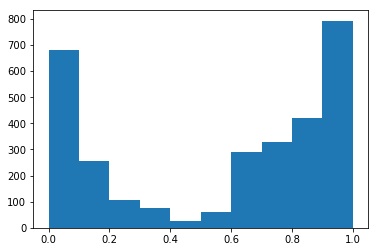

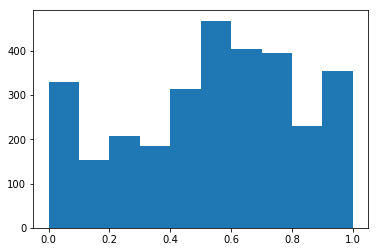

In [106]:
# Extract other features

def plot_figure(x):
    plt.figure()
    plt.hist(x)
    plt.show()
    

subTTFe = allTData[['giver_username_if_known', 
                    'number_of_downvotes_of_request_at_retrieval', 
                    'number_of_upvotes_of_request_at_retrieval',
                    'request_number_of_comments_at_retrieval',
                    'requester_account_age_in_days_at_request',
                    'requester_number_of_comments_at_request', 
                    'requester_number_of_comments_in_raop_at_request', 
                    'requester_number_of_posts_at_request', 
                    'requester_number_of_subreddits_at_request', 
                    'requester_upvotes_minus_downvotes_at_request', 
                    'requester_upvotes_minus_downvotes_at_retrieval', 
                    'requester_upvotes_plus_downvotes_at_request', 
                    'requester_upvotes_plus_downvotes_at_retrieval']]
subDTFe = allDData[['giver_username_if_known', 
                    'number_of_downvotes_of_request_at_retrieval', 
                    'number_of_upvotes_of_request_at_retrieval',
                    'request_number_of_comments_at_retrieval',
                    'requester_account_age_in_days_at_request',
                    'requester_number_of_comments_at_request', 
                    'requester_number_of_comments_in_raop_at_request', 
                    'requester_number_of_posts_at_request', 
                    'requester_number_of_subreddits_at_request', 
                    'requester_upvotes_minus_downvotes_at_request', 
                    'requester_upvotes_minus_downvotes_at_retrieval', 
                    'requester_upvotes_plus_downvotes_at_request', 
                    'requester_upvotes_plus_downvotes_at_retrieval']]

# Convert first col to numerical

temp = 1*(subTTFe['giver_username_if_known']!='N/A').values
subTTFe = subTTFe.drop('giver_username_if_known',1).values

temp = np.reshape(temp,(-1,1))
subTTFe = np.concatenate((subTTFe,temp), axis=1)

#print(subTTFe[1])

temp = 1*(subDTFe['giver_username_if_known']!='N/A').values
subDTFe = subDTFe.drop('giver_username_if_known',1).values

temp = np.reshape(temp,(-1,1))
subDTFe = np.concatenate((subDTFe,temp), axis=1)


# Create new features

# Upvote minus downvotes at request - upvote minus downvote at retrieval

temp = np.reshape((subTTFe[:,10] - subTTFe[:,9]),(-1,1))
subTTFe = np.concatenate((subTTFe,temp),axis=1)

temp = np.reshape((subDTFe[:,10] - subDTFe[:,9]),(-1,1))
subDTFe = np.concatenate((subDTFe,temp),axis=1)

# Hour and Month of request

unixT = allTData[['unix_timestamp_of_request_utc']].copy()
unixD = allDData[['unix_timestamp_of_request_utc']].copy()

# Convert from unix > datetime
unixT['Datetime'] = pandas.to_datetime(unixT['unix_timestamp_of_request_utc'], unit='s')
unixT['Hour'] = unixT['Datetime'].dt.hour
unixT['Month'] = unixT['Datetime'].dt.month
unixT = unixT.drop(['Datetime','unix_timestamp_of_request_utc'], axis=1)
unixT = unixT.values

unixD['Datetime'] = pandas.to_datetime(unixD['unix_timestamp_of_request_utc'], unit='s')
unixD['Hour'] = unixD['Datetime'].dt.hour
unixD['Month'] = unixD['Datetime'].dt.month
unixD = unixD.drop(['Datetime','unix_timestamp_of_request_utc'], axis=1)
unixD = unixD.values

print(subTTFe.shape, unixT.shape)
print(subDTFe.shape, unixD.shape)

subTTFe = np.concatenate((subTTFe,unixT),axis=1)
subDTFe = np.concatenate((subDTFe,unixD),axis=1)

# Scale features

from scipy.stats import describe

print(describe(subTTFe[:,0]))

n1 = preprocessing.MinMaxScaler().fit_transform(subTTFe)
n2 = preprocessing.MinMaxScaler().fit_transform(subDTFe)

print(n1.shape)

for i in range(14,16):
    plot_figure(n1[:,i])



In [99]:
## PARAMETER 2:  TIMEDATE STAMP OF REDDIT POST ##


print(unix)
print(unix.shape)



[[14  9]
 [ 0  8]
 [ 6  3]
 ..., 
 [14  5]
 [15  2]
 [22  2]]
(3040, 2)


# Feature Selection

In [107]:
#Variance Threshold
"""
sel = VarianceThreshold(threshold=(0.8*(1-0.8)))
tVector = sel.fit_transform(tVector)
dVector = sel.transform(dVector)
"""

# Select k best
#sel = SelectKBest(chi2, k=8)

# Select percentile
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

sel = SelectPercentile(mutual_info_classif, percentile=10)
tVector = sel.fit_transform(tVector,trainLabel)
tVector_p = sel.fit_transform(tVector_p,trainLabel)
dVector = sel.fit_transform(dVector,devLabel)
dVector_p = sel.fit_transform(dVector_p,devLabel)

#nb = BernoulliNB(alpha=0.01).fit(tVector,trainLabel)
#model = SelectFromModel(nb, prefit=True)
#tVector = model.transform(tVector)
#dVector = model.transform(dVector)


print(tVector.shape)
print(dVector.shape)

(3040, 511)
(1000, 511)


In [108]:
print(tVector.shape)
print(n1.shape)

tVector = np.concatenate((tVector.toarray(),n1),axis=1)
tVector_p = np.concatenate((tVector_p.toarray(),n1),axis=1)
dVector = np.concatenate((dVector.toarray(),n2),axis=1)
dVector_p = np.concatenate((dVector_p.toarray(),n2),axis=1)


(3040, 511)
(3040, 16)


# Section 3. Baseline Models

## 3.1 Subreddit Models

## Logistic Regression

In [109]:
def roc_curve1(y_true, y_pred_prob):
    """This function plots the ROC curve
    Inputs: y_true, correct label
            y_pred_prob, predicted probabilities
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
   
    plt.figure()
    plt.plot(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.show()
    

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    


# Logistic Regressions

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.798
Area under curve of ROC:  0.627754677755
Classification report:

             precision    recall  f1-score   support

      False       0.79      0.98      0.88       740
       True       0.85      0.27      0.41       260

avg / total       0.81      0.80      0.76      1000

---------------------------------------------------------------------------


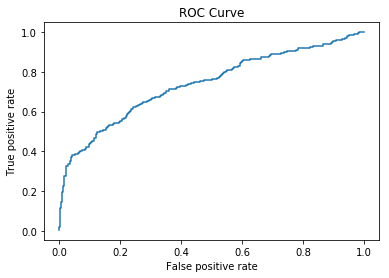

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.774
Area under curve of ROC:  0.565384615385
Classification report:

             precision    recall  f1-score   support

      False       0.77      1.00      0.87       740
       True       1.00      0.13      0.23       260

avg / total       0.83      0.77      0.70      1000

---------------------------------------------------------------------------


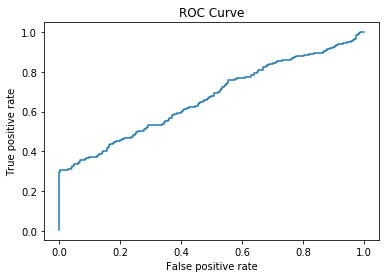

In [110]:
# Logistic Regression

C = 0.01 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.decision_function(dVector))


modelLogit.fit(tVector_p,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.decision_function(dVector_p))




## Naive Bayes

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.313
Area under curve of ROC:  0.532068607069
Classification report:

             precision    recall  f1-score   support

      False       0.95      0.08      0.14       740
       True       0.27      0.99      0.43       260

avg / total       0.77      0.31      0.22      1000

---------------------------------------------------------------------------


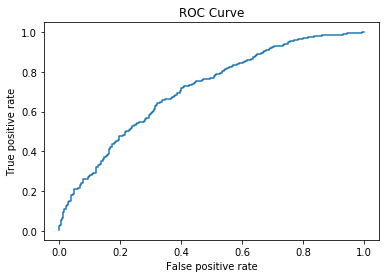

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.745
Area under curve of ROC:  0.697972972973
Classification report:

             precision    recall  f1-score   support

      False       0.85      0.80      0.82       740
       True       0.51      0.60      0.55       260

avg / total       0.76      0.74      0.75      1000

---------------------------------------------------------------------------


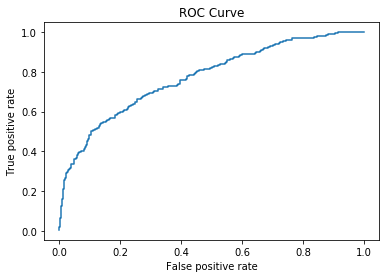

In [111]:
# Multinomial NB

alpha = 0.01

clf = BernoulliNB(alpha=alpha)

clf.fit(tVector, trainLabel)
score_rep(devLabel, clf.predict(dVector),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, -clf.predict_log_proba(dVector)[:,0])


clf.fit(tVector_p, trainLabel)
score_rep(devLabel,clf.predict(dVector_p),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, -clf.predict_log_proba(dVector_p)[:,0])


Random Forest
---------------------------------------------------------------------------
Accuracy:  0.805
Area under curve of ROC:  0.69235966736
Classification report:

             precision    recall  f1-score   support

      False       0.83      0.93      0.88       740
       True       0.69      0.46      0.55       260

avg / total       0.79      0.81      0.79      1000

---------------------------------------------------------------------------


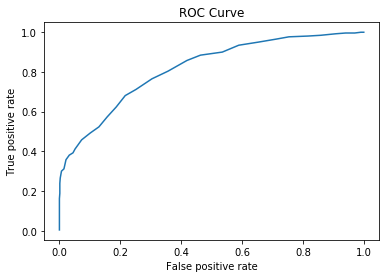

Random Forest
---------------------------------------------------------------------------
Accuracy:  0.82
Area under curve of ROC:  0.677546777547
Classification report:

             precision    recall  f1-score   support

      False       0.82      0.97      0.89       740
       True       0.84      0.38      0.52       260

avg / total       0.82      0.82      0.79      1000

---------------------------------------------------------------------------


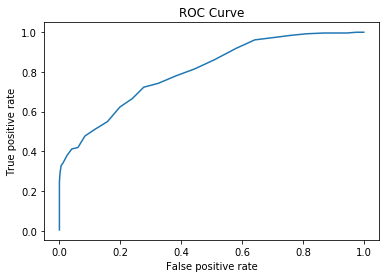

In [112]:
RF = RandomForestClassifier(n_estimators=50)

RF.fit(tVector, trainLabel)
score_rep(devLabel, RF.predict(dVector),'Random Forest')
roc_curve1(devLabel, -RF.predict_proba(dVector)[:,0])


RF.fit(tVector_p, trainLabel)
score_rep(devLabel,RF.predict(dVector_p),'Random Forest')
roc_curve1(devLabel, -RF.predict_proba(dVector_p)[:,0])

# Reducing vocabulary (doesn't work)


Logistic Regression f1-score with C =  0.100:
0.0569395017794
Number of non-zero elements: 61
Vocabulary size: 61

Logistic Regression (using l2) f1-score with C =  0.100:
0.138613861386
Logistic Regression
---------------------------------------------------------------------------
Accuracy:  0.739
Area under curve of ROC:  0.52551975052
Classification report:

             precision    recall  f1-score   support

      False       0.75      0.97      0.85       740
       True       0.49      0.08      0.14       260

avg / total       0.68      0.74      0.66      1000

---------------------------------------------------------------------------

Logistic Regression f1-score with C =  1.000:
0.297169811321
Number of non-zero elements: 1105
Vocabulary size: 1105

Logistic Regression (using l2) f1-score with C =  1.000:
0.284403669725
Logistic Regression
---------------------------------------------------------------------------
Accuracy:  0.688
Area under curve of ROC:  0.542203742204

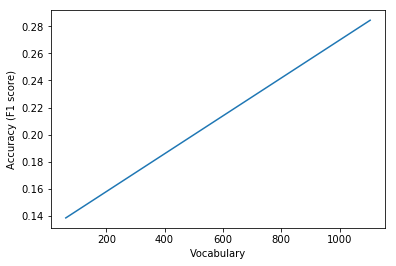

In [36]:

# Keep this random seed here to make comparison easier.
np.random.seed(101)

### STUDENT START ###

# Countvectorizer options: turns on lower case, strip accents, and stop-words
vectorizer = CountVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,4))

def LR1(C):

    """
    Function estimates an LR with l1 regularization and counts number of nonzero weights
    Returns coefficient array
    """

    # Preprocess data
    train_data_v = vectorizer.fit_transform(data_preprocessor(trainCorpus))
    dev_data_v = vectorizer.transform(data_preprocessor(devCorpus))

    # Run the LR regression, l1 regularization, solving using liblinear [note: l1 doesn't work with multinomial]
    clf = LogisticRegression(penalty='l1', C=C)
    clf.fit(train_data_v,trainLabel)
    test_predicted_labels = clf.predict(dev_data_v)

    print ('\nLogistic Regression f1-score with C = %6.3f:' %C )
    print (metrics.f1_score(devLabel,test_predicted_labels))
    print ('Number of non-zero elements: %d' %(np.count_nonzero(clf.coef_)))

    return clf.coef_

def LR2(C,lvocab):
    """
    Calls LR with l2 for given vocab
    Returns vocab size and accuracy
    """

    # Define new vectorizer with vocab = vocab
    vectorizer1 = CountVectorizer(lowercase=True, strip_accents='unicode',
                                  stop_words='english',vocabulary=lvocab)

    # Preprocess data using new vectorizer
    train_data_v1 = vectorizer1.fit_transform(data_preprocessor(trainCorpus))
    dev_data_v1 = vectorizer1.transform(data_preprocessor(devCorpus))

    # Run the LR regression, l2 regularization, solving using sag
    clf1 = LogisticRegression(penalty='l2', tol=0.01, C=C)
    clf1.fit(train_data_v1,trainLabel)
    test_predicted_labels = clf1.predict(dev_data_v1)

    print ('\nLogistic Regression (using l2) f1-score with C = %6.3f:' %C )
    print (metrics.f1_score(devLabel,test_predicted_labels))
    score_rep(devLabel,test_predicted_labels,'Logistic Regression')


    return (len(lvocab),metrics.f1_score(devLabel,test_predicted_labels) )

def create_vocab_list(s):
    """
    inputs - clf.coef_
    output - list of vocabulary
    creates a list of vocabulary corresponding to non-zero features
    """

    def build_vocab (s):
        temp = []
        for i in range (len(s)):
            temp.append(s[i])
        return temp

    def build_vocab_list(s):
        temp = []
        for i in range(1):
            y = np.nonzero(s[i])
            y = list(y[0])
            temp = temp + build_vocab(y)
        temp = list(set(temp))    
        return temp

    vocab = build_vocab_list(s) 

    x = vectorizer.get_feature_names()

    temp = []

    for vocab in vocab:
        temp.append(x[vocab])

    return temp

# Main program

C = [1e-1, 1] #2, 5, 10, 20, 50, 100, 200, 500, 1000 ] # Run over various C

a, b = [], []
for C in C:
    z = LR1(C) # Call this function to estimate LR with L1, z is the matrix of coef
    lvocab = create_vocab_list(z) # Call this function to create vocab list where coef not equal zero
    print ('Vocabulary size: %d' %len(lvocab))
    x, y = LR2(C,lvocab) # Call new LR estimate with L2
    a.append(x)
    b.append(y)

# Plot vocabulary size vs accuracy

plt.plot(a,b)
plt.xlabel('Vocabulary')
plt.ylabel('Accuracy (F1 score)')
plt.show()



# Using l1 to choose features (doesn't work)

For C =  0.0001 Logistic regression accuracy: 0.74
Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------
For C =  0.001 Logistic regression accuracy: 0.74
Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

-----------------------------------------

/home/levi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For C =  10.0 Logistic regression accuracy: 0.677
Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.677
Area under curve of ROC:  0.544750519751
Classification report:

             precision    recall  f1-score   support

      False       0.76      0.82      0.79       740
       True       0.34      0.27      0.30       260

avg / total       0.65      0.68      0.66      1000

---------------------------------------------------------------------------
Logistic Regression
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------


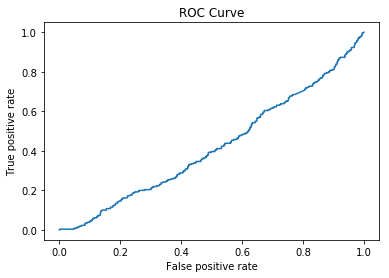

1.82783966463

Top 5 Weighted Features:
1746
budgeted 0.81505745361
1082
beautifu 0.909324213061
2418
cities 1.19639445542
857
awesome help 1.19926956084
1397
boss 1.82783966463


In [28]:
# get the best regularization
regStrength = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 6.0, 10.0]


for c in regStrength:
    modelLogit = LogisticRegression(penalty='l1', C=c)
    modelLogit.fit(tVector_p, trainLabel)
    logitScore = round(modelLogit.score(dVector_p, devLabel), 4)
    print("For C = ", c, "Logistic regression accuracy:", logitScore)
    score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.01')


# although the best score comes from c=.001, the bet F1-score 
# comes from c=.5, and this gives better weight options
modelLogit = LogisticRegression(penalty='l1', C=.5, tol = .1)
modelLogit.fit(tVector_p, trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression')
roc_curve1(devLabel, modelLogit.predict_proba(dVector_p)[:,0])


print(max(modelLogit.coef_[0]))
numWeights = 5

sortIndex = np.argsort(modelLogit.coef_)
iLen = len(sortIndex[0])
print("\nTop", numWeights, "Weighted Features:")

for index in range((iLen - numWeights) , iLen):
    lookup = sortIndex[0][index]
    print(lookup)
    weight =  modelLogit.coef_[0][lookup]
    print(vectorizer.get_feature_names()[sortIndex[0][index]], weight)

# PCA/LDA to reduce dimension

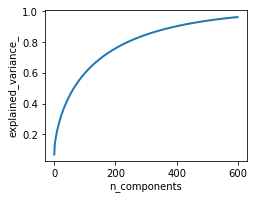

Random Forest
---------------------------------------------------------------------------
Accuracy:  0.739
Area under curve of ROC:  0.505561330561
Classification report:

             precision    recall  f1-score   support

      False       0.74      0.99      0.85       740
       True       0.45      0.02      0.04       260

avg / total       0.67      0.74      0.64      1000

---------------------------------------------------------------------------


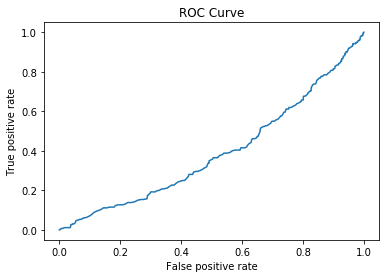

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.716
Area under curve of ROC:  0.546153846154
Classification report:

             precision    recall  f1-score   support

      False       0.76      0.90      0.82       740
       True       0.40      0.19      0.26       260

avg / total       0.67      0.72      0.68      1000

---------------------------------------------------------------------------


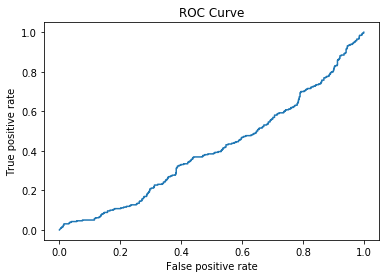

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.656
Area under curve of ROC:  0.538045738046
Classification report:

             precision    recall  f1-score   support

      False       0.76      0.78      0.77       740
       True       0.32      0.29      0.31       260

avg / total       0.65      0.66      0.65      1000

---------------------------------------------------------------------------


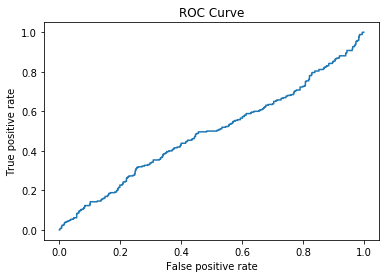

In [56]:
pca = TruncatedSVD(n_components=600)

vectorizer = CountVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,1))

tVector = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector = vectorizer.transform(data_preprocessor(devCorpus))

#print(tVector.shape)

tVector_s = pca.fit(tVector)
dVector_s = pca.fit(dVector)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

RF = RandomForestClassifier(n_estimators=600)

RF.fit(tVector, trainLabel)
score_rep(devLabel, RF.predict(dVector),'Random Forest')
roc_curve1(devLabel, RF.predict_proba(dVector)[:,0])


alpha = 0.01

clf = BernoulliNB(alpha=alpha)

clf.fit(tVector, trainLabel)
score_rep(devLabel, clf.predict(dVector),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, clf.predict_proba(dVector)[:,0])

C = 100 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.predict_proba(dVector)[:,0])




# NLTK Modules

In [12]:
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words(trainCorpus)

unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
print(len(unigram_feats))
print(unigram_feats)

sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

training_set = sentim_analyzer.apply_features(trainCorpus)
test_set = sentim_analyzer.apply_features(devCorpus)





97
[' ', 'e', 't', 'o', 'a', 'n', 'i', 's', 'r', 'h', 'l', 'd', 'u', 'm', 'y', 'g', 'f', 'p', 'c', 'w', '.', 'b', 'I', 'k', 'v', ',', 'z', "'", '\n', 'R', 'T', ']', 'S', '[', 'A', 'q', 'j', 'E', '!', ')', 'M', 'P', '(', 'W', '/', 'H', ':', 'x', 'U', 'C', '-', 'N', 'O', 'D', 'F', 'B', '2', 'L', '0', '1', 'Q', '?', '3', '*', 'G', 'J', '5', 'Y', '4', ';', '"', 'K', '_', '$', '6', '7', 'V', '8', '&', '9', 'Z', 'X', '=', '~', '+', '}', '{', '%', '£', '^', '#', '\r', 'é', '@', '\\', '|', '`']


## User Status models

In [21]:
# LOGISTIC REGRESSION MODELS
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')

# create training labels for pizza success
train_labels = np.asarray(allTData['requester_received_pizza'])
dev_labels = np.asarray(allDData['requester_received_pizza'])

# Trial 1: Request / Retrieval 
diff_alone = np.asarray(statusTtrain[['Request', 'Retrieval']].copy())
diff_dev_alone = np.asarray(statusDtrain[['Request', 'Retrieval']].copy())
train_model = lr.fit(diff_alone, train_labels)
dev_alone_labels = train_model.predict(diff_dev_alone)
alone_score = train_model.score(diff_dev_alone, dev_labels)
alone_F1score = metrics.f1_score(dev_alone_labels, dev_labels)
print("For model with Request/Retrieval/Request-Retrieval Difference only")
print("Accuracy:", alone_score)
print("F1 score:", alone_F1score)

# Trial 2:  Z-scores for Request / Retrieval 
zdiff_train = statusTtrain[['Request Z-score','Retrieval Z-score']]
zdiff_dev = statusDtrain[['Request Z-score','Retrieval Z-score']]
zdiff_model = lr.fit(zdiff_train, train_labels)
zdiff_labels = zdiff_model.predict(zdiff_dev)
zdiff_score = zdiff_model.score(zdiff_dev, dev_labels)
zdiff_F1score = metrics.f1_score(zdiff_labels, dev_labels)
print("\nFor model with Request / Retrieval Z-scores only :")
print("Accuracy:", zdiff_score)
print("F1 score:", zdiff_F1score)

# Trial 3:  Z-scores for Request-Retrieval 
# Create Z-scores request-retrieval
diff_combined = np.asarray(statusTtrain[['Request-Retrieval Z-score']].copy())
diff_dev_combined = np.asarray(statusDtrain[['Request-Retrieval Z-score']].copy())
train_combine_model = lr.fit(diff_combined, train_labels)
dev_combine_labels = train_combine_model.predict(diff_dev_combined)
combine_score = train_combine_model.score(diff_dev_combined, dev_labels)
combine_F1score = metrics.f1_score(dev_combine_labels, dev_labels)
print("\nFor model with Request-Retrieval Z-Score only")
print("Accuracy:", combine_score)
print("F1 score:", combine_F1score)

# Trial 4:  Z-scores for Request / Retrieval / Diff / Flair
zcomb_train = statusTtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_train.replace(['None', 'shroom', 'PIF'], [-1, 0, 1])

zcomb_dev = statusDtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_dev.replace(['None', 'shroom', 'PIF'], [-1, 0, 1])

zcomb_model = lr.fit(zcomb_train, train_labels)
zcomb_labels = zcomb_model.predict(zcomb_dev)
zcomb_score = zcomb_model.score(zcomb_dev, dev_labels)
zcomb_F1score = metrics.f1_score(zcomb_labels, dev_labels)
print("\nZ-scores for Request / Retrieval:")
print("Accuracy:", zcomb_score)
print("F1 score:", zcomb_F1score)

For model with Request/Retrieval/Request-Retrieval Difference only
Accuracy: 0.737
F1 score: 0.0

For model with Request / Retrieval Z-scores only :
Accuracy: 0.737
F1 score: 0.0

For model with Request-Retrieval Z-Score only
Accuracy: 0.738
F1 score: 0.0


ValueError: could not convert string to float: 'shroom'

# Future Steps

* More data pre-processing (looking for newer features too)
* Explore PCA/LSA
* Ideas on features
    - Combination of words
    - Pruning
    - Timing (of requests)
    - Location
    

In [52]:

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 28.130s.
Extracting tf-idf features for NMF...
done in 0.389s.
Extracting tf features for LDA...
done in 0.344s.
Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.200s.

Topics in NMF model:
Topic #0:
just people don think like know time good make way really say right ve want did ll new use years
Topic #1:
windows use dos using window program os drivers application help software pc running ms screen files version card code work
Topic #2:
god jesus bible faith christian christ christians does heaven sin believe lord life church mary atheism belief human love religion
Topic #3:
thanks know does mail advance hi info interested email anybody looking card help like appreciated information send list video need
Topic #4:
car cars tires miles 00 new engine insurance price condition oil power speed good 000 brake year models used bought
Topic #5:
edu soon com send university internet mit ftp mail cc pub article information hop

In [ ]:
def print_top_names(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
# Applying LDA
#lda = LDA(n_topics=100, max_iter=5,learning_method='online', learning_offset=50.,
#          random_state=0)
#lda.fit(tVector)

#print("\nTopics in LDA model:")
#tf_feature_names = vectorizer.get_feature_names()
#print_top_words(lda, tf_feature_names,20)

#lda = LinearDiscriminantAnalysis(n_components=10)
#X_r2 = lda.fit(tVector, trainLabel).transform(tVector)



